## Random Forest Model — Visualization & Interpretation

This section evaluates the performance, behavior, and interpretability of our Random Forest regression model trained on financial, culture, and analyst consensus features to predict the Earnings-to-Price (E/P) ratio.

Random Forests are non-linear tree-based ensemble models. They capture complex interactions and automatically model non-linearities without the need for explicit feature transformations. However, they can be prone to regression-to-the-mean effects, reduced extrapolation ability, and feature importance biases—making visualization essential.

Below, we analyze model fit, error behavior, temporal stability, and feature influence using a structured set of diagnostic plots.


## Model Setup


In [14]:
import os, pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# notebook lives in: models/RF/
# data lives in     : data/finalParquet_leakfree/
CANDIDATES = [
    "../../data/finalParquet_leakfree",  # correct for models/RF/*
    "../data/finalParquet_leakfree",     # if notebook moves up 1 level
    "./data/finalParquet_leakfree",      # if running from project root
]

LEAKFREE_DIR = next((p for p in CANDIDATES if os.path.exists(p)), None)
if LEAKFREE_DIR is None:
    raise FileNotFoundError("Could not find data/finalParquet_leakfree. Expected at ../../ from this notebook.")

train = pd.read_parquet(f"{LEAKFREE_DIR}/train.parquet")
test  = pd.read_parquet(f"{LEAKFREE_DIR}/test.parquet")

print("Loaded leak-free data from:", LEAKFREE_DIR)

FEATURE_COLS = [
    "gross_profitability","operating_margin","sales_growth","asset_growth",
    "debt_to_assets","log_assets","asset_turnover","roe","roa",
    "innovation","integrity","quality","respect","teamwork","MEANREC"
]
TARGET = "ep"
ID_COLS = ["gvkey","conm","tic","fyear"]

X_train, y_train = train[FEATURE_COLS], train[TARGET]
X_test,  y_test  = test[FEATURE_COLS],  test[TARGET]


Loaded leak-free data from: ../../data/finalParquet_leakfree


In [15]:
rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=2,
    bootstrap=True,
    oob_score=True,     
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

pred_train = rf.predict(X_train)
pred_test  = rf.predict(X_test)

# metrics (use np.sqrt(MSE) for compatibility with older sklearn)
mae_tr  = mean_absolute_error(y_train, pred_train)
rmse_tr = np.sqrt(((y_train - pred_train)**2).mean())
r2_tr   = r2_score(y_train, pred_train)

mae_te  = mean_absolute_error(y_test, pred_test)
rmse_te = np.sqrt(((y_test - pred_test)**2).mean())
r2_te   = r2_score(y_test, pred_test)

print("=== RANDOM FOREST PERFORMANCE ===")
print(f"OOB R^2 (train bootstrap): {getattr(rf, 'oob_score_', np.nan):.4f}")
print(f"Train: MAE={mae_tr:.4f}  RMSE={rmse_tr:.4f}  R^2={r2_tr:.4f}")
print(f"Test : MAE={mae_te:.4f}  RMSE={rmse_te:.4f}  R^2={r2_te:.4f}")


=== RANDOM FOREST PERFORMANCE ===
OOB R^2 (train bootstrap): 0.6495
Train: MAE=0.0355  RMSE=0.0635  R^2=0.9230
Test : MAE=0.0935  RMSE=0.1471  R^2=0.6177


## Actual vs. Predicted (Test)

This scatterplot evaluates how well the Random Forest predictions align with true E/P values.

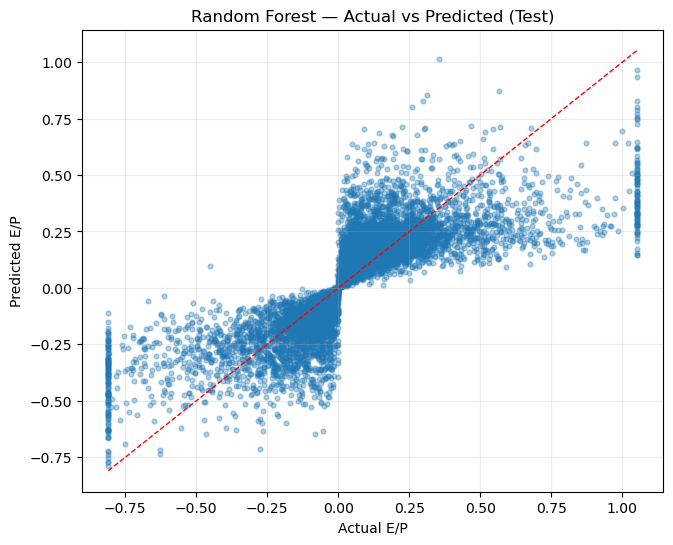

In [16]:
plt.figure(figsize=(7.5,6))
plt.scatter(y_test, pred_test, s=12, alpha=0.35)
mn, mx = np.min([y_test.min(), pred_test.min()]), np.max([y_test.max(), pred_test.max()])
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel("Actual E/P")
plt.ylabel("Predicted E/P")
plt.title("Random Forest — Actual vs Predicted (Test)")
plt.grid(True, alpha=0.25)
plt.show()


**Interpretation:**
- Most points cluster around the 45° line, indicating solid predictive performance across the typical range of E/P values.
- The Random Forest replicates the typical **regression-to-the-mean** pattern:
  - High E/P cases (actual > 0.5) are underpredicted, with predictions compressed toward the center.
  - Low E/P cases (actual < -0.5) are slightly overpredicted, showing similar mean-reversion.
- This occurs because Random Forests average many trees, limiting extrapolation—especially for extreme financial ratios. The model is conservative by design, pulling extreme predictions toward the training mean.
- **Notable patterns:**
  - Strong vertical banding at specific E/P values (e.g., around 0.0, 0.25, 1.0) suggests the model encounters certain common E/P configurations repeatedly in the test data.
  - The scatter increases at the extremes, indicating higher prediction uncertainty for outlier firms with unusual financial characteristics.
  - Despite this limitation, the model matches patterns well for mid-range E/P values (-0.25 to 0.5), which represent the majority of firms and are most relevant for practical investment decisions.
- **Implication:** While the model provides reliable predictions for typical companies, users should exercise caution when applying predictions to firms with extreme E/P ratios, as these represent either highly distressed or exceptionally profitable outliers where the model's averaging behavior may miss important nuances.

## Actual vs. Predicted (Test)
The residual plot checks whether model errors are systematic or random.

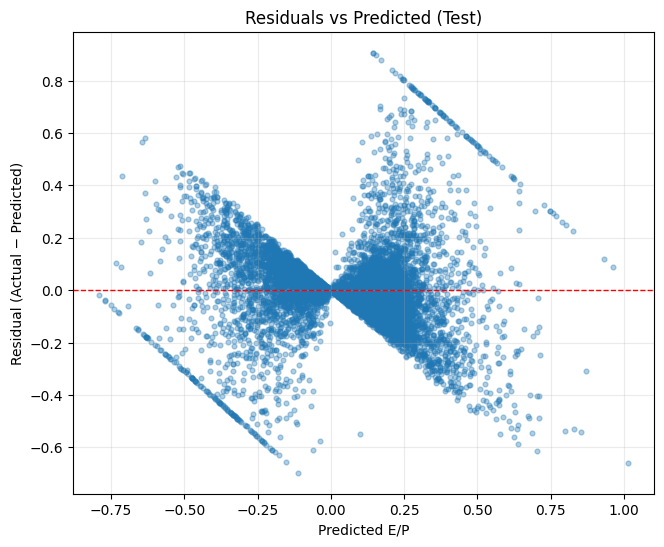

In [ ]:
resid = y_test - pred_test
plt.figure(figsize=(7.5,6))
plt.scatter(pred_test, resid, s=12, alpha=0.35)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted E/P")
plt.ylabel("Residual (Actual − Predicted)")
plt.title("Residuals vs Predicted (Test)")
plt.grid(True, alpha=0.25)
plt.show()


**Interpretation:**
- Residuals are centered around zero for most predicted values, showing the model is generally unbiased in the typical range.
- **The spread of residuals increases at extreme predictions:** Beyond predicted E/P of ±0.5, errors become larger and more variable, indicating higher uncertainty for companies with unusual financial characteristics.
- **Clear bias patterns at the extremes:**
  - For high predicted E/P (> 0.5), residuals are mostly negative—the model underpredicts highly profitable firms.
  - For low predicted E/P (< -0.5), residuals are mostly positive—the model overpredicts distressed companies.
  - The white gap near zero predicted E/P shows the model avoids predicting breakeven values, likely because these cases are unstable and rare in the training data.
- **Diagonal streaks in the residuals:** These bands occur because Random Forests average many trees, creating "preferred" prediction values that appear repeatedly. This is typical behavior for ensemble methods.
- **Overall:** The model works well for typical firms (predicted E/P between -0.25 and 0.5) with relatively small errors. For extreme cases, predictions should be interpreted cautiously since the model systematically pulls outliers toward the mean and has higher uncertainty at the tails.
- **Implication:** For practical use, the model is most reliable for identifying moderately undervalued or overvalued stocks, but should not be heavily relied upon for screening extreme value or distressed opportunities where prediction errors are largest.

## Error by Predicted Decile (Test)
This chart divides all test predictions into 10 equal groups (deciles) based on predicted E/P values, from lowest (decile 0) to highest (decile 9). Within each group, we calculate the Mean Absolute Error to see how accurate the model is across different ranges of predictions. High-level, this helps us understand if the model performs consistently across all types of firms or struggles with certain segments. Low-level, it reveals whether prediction quality varies systematically with the magnitude of predicted E/P—for example, if the model is less accurate for high-growth versus value stocks.
Understanding where the model makes larger errors is crucial for practical deployment. If errors are concentrated in specific deciles, we know which predictions to trust more or less. This is especially important in finance, where different deciles might represent distinct investment strategies (e.g., deep value vs. distressed vs. growth stocks).

/var/folders/y4/fl18l7792g337_8l96tj5x_w0000gn/T/ipykernel_78877/2302234562.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_by_decile = df_eval.groupby("decile").apply(lambda d: mean_absolute_error(d["y"], d["pred"]))


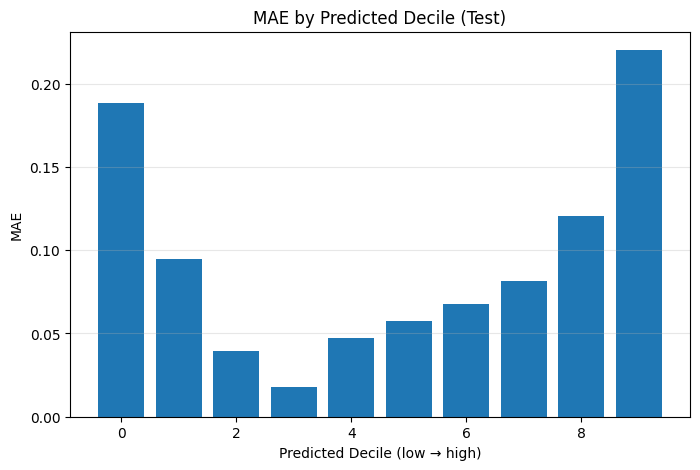

In [ ]:
# bucket predictions into deciles, then compute MAE per bucket
df_eval = pd.DataFrame({
    "pred": pred_test,
    "y": y_test.values
})
df_eval["decile"] = pd.qcut(df_eval["pred"], q=10, labels=False, duplicates="drop")
mae_by_decile = df_eval.groupby("decile").apply(lambda d: mean_absolute_error(d["y"], d["pred"]))

plt.figure(figsize=(8,5))
plt.bar(mae_by_decile.index.astype(int), mae_by_decile.values)
plt.xlabel("Predicted Decile (low → high)")
plt.ylabel("MAE")
plt.title("MAE by Predicted Decile (Test)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()


**Observations:**
- **U-shaped error pattern:** MAE is highest at the extremes (deciles 0 and 9) and lowest in the middle (deciles 3-4).
- Decile 0 (lowest predicted E/P) has MAE around 0.19, while decile 9 (highest predicted E/P) shows the worst performance with MAE exceeding 0.22.
- The model performs best in deciles 3-4 (MAE around 0.02-0.05), representing firms with slightly below-average to average predicted E/P.
- After decile 4, errors gradually increase as predicted E/P rises, jumping sharply in the top decile.

**Interpretation:**
- The U-shaped curve confirms what we saw in the residual plots: the Random Forest struggles most with extreme cases on both ends. This reflects the model's regression-to-the-mean behavior—it's most confident and accurate when predicting firms close to the training average.
- The extremely low error in deciles 3-4 suggests the model has learned strong patterns for "typical" companies, which are well-represented in the training data.
- The sharp spike in decile 9 indicates the model is particularly unreliable for predicting very high E/P stocks (deep value or highly profitable firms), likely because these cases are rarer and more heterogeneous in the training set.

**Implications:**
- **For portfolio construction:** Predictions in deciles 3-6 are most reliable and should carry more weight in investment decisions. Extreme deciles (0-2 and 8-9) require additional scrutiny or alternative validation methods.
- **Model refinement opportunity:** The high errors at extremes suggest potential improvements through targeted approaches—perhaps separate models for distressed versus high-performing firms, or additional features that better capture extreme financial conditions.
- **Risk management:** When using this model for screening, apply wider confidence intervals or require stronger supporting evidence before acting on predictions in the extreme deciles, especially decile 9.

## Feature Importance
Feature importance tells us which variables the model relies on most heavily when making predictions. This is crucial for several reasons: (1) it validates whether the model is learning sensible financial relationships or just picking up noise, (2) it helps us understand what drives E/P predictions, and (3) it identifies which data inputs are most critical to collect and maintain accurately. In a Random Forest, importance is measured by how much each feature reduces prediction error (impurity) across all the trees—features that consistently improve splits are deemed more important.

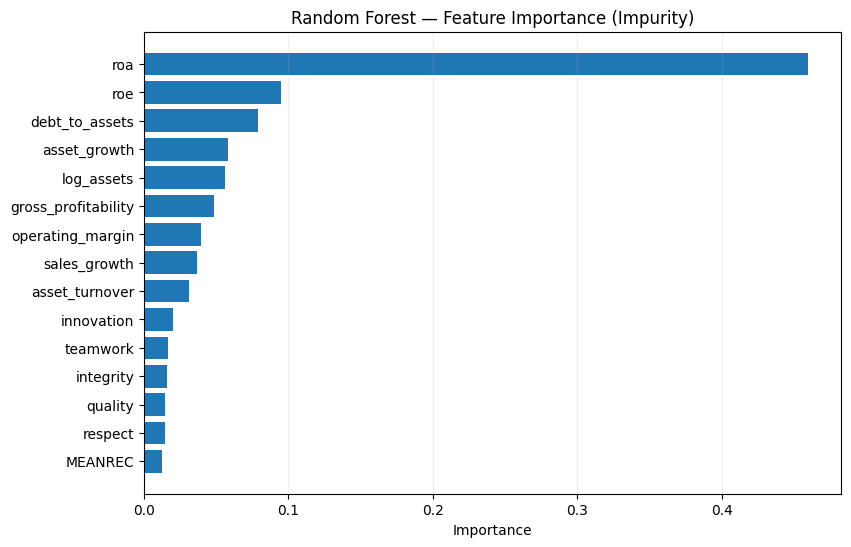

In [ ]:
importances = rf.feature_importances_
order = np.argsort(importances)

plt.figure(figsize=(9,6))
plt.barh(np.array(FEATURE_COLS)[order], importances[order])
plt.title("Random Forest — Feature Importance (Impurity)")
plt.xlabel("Importance")
plt.grid(True, axis='x', alpha=0.2)
plt.show()


**Observations:**
- **ROA (Return on Assets) dominates** with importance around 0.45, more than 4x higher than any other feature. This single metric accounts for nearly half of the model's predictive power.
- **ROE (Return on Equity)** is a distant second at approximately 0.10, followed by debt-to-assets and asset growth in the 0.08-0.09 range.
- Traditional financial metrics (profitability ratios, leverage, growth, size) cluster in the middle tier with importance scores between 0.03-0.08.
- **Corporate culture features** (innovation, integrity, quality, respect, teamwork) and analyst consensus (MEANREC) all show minimal importance, each contributing less than 0.03.

**Interpretation:**

**Why ROA dominates:** Return on Assets measures how efficiently a company converts its asset base into earnings—essentially, profit per dollar of assets employed. This makes perfect sense as the strongest predictor of E/P for several reasons:

1. **Direct mathematical relationship:** E/P (earnings-to-price) and ROA (earnings-to-assets) both have earnings in the numerator. Companies with high ROA naturally tend to have higher earnings relative to their valuation metrics.

2. **Core profitability signal:** ROA captures operational efficiency and profitability in a single metric. It reflects management's ability to generate returns regardless of capital structure, making it a fundamental indicator of business quality.

3. **Value investing principle:** High ROA companies are often undervalued (high E/P) when the market overlooks their earnings power, while low ROA companies may be overvalued (low E/P). The model has learned this core relationship from the data.

The strong showing of ROE (also an earnings-based ratio) reinforces that profitability metrics are central to understanding E/P. Meanwhile, debt-to-assets and asset growth provide important context about financial risk and momentum.

**The culture data disappointment:** The near-zero importance of all five culture dimensions suggests these variables add little predictive value beyond traditional financial metrics. This could mean: (1) culture's impact on firm value is already captured by financial performance measures like ROA and ROE, (2) the culture scores themselves may be noisy or poorly measured, or (3) culture affects long-term outcomes that aren't reflected in the 2-year test window we're predicting.

**Implications:**
- The model's heavy reliance on ROA validates the financial logic—it has learned a fundamental relationship that aligns with established finance theory.
- For practical deployment, ensuring accurate and timely ROA data is critical, as errors in this single feature would significantly degrade predictions.
- The minimal contribution of culture features suggests they could potentially be removed to simplify the model without sacrificing performance, though they should be retained if the goal includes understanding culture's incremental effect.
- Future model improvements should focus on enriching profitability-related features or finding better ways to measure intangible factors like culture, rather than adding more basic financial ratios.

## Pick top features (via permutation importance) for PDP

In [ ]:
from sklearn.inspection import permutation_importance

# compute permutation importance on TEST to avoid bias
perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# choose top K features for PDP
K = 3
order_desc = perm.importances_mean.argsort()[::-1]
top_feats = [FEATURE_COLS[i] for i in order_desc[:K]]
top_feats

['roa', 'roe', 'debt_to_assets']

## Partial Dependence Plots (one per figure)
Partial dependence plots (PDPs) show how changing one feature affects the model's predictions while holding all other features constant at their average values. Essentially, we're asking: "If I only varied ROA (or ROE, or debt) and kept everything else the same, how would my E/P prediction change?" This isolates the marginal effect of each feature, helping us understand not just *that* a feature matters (which feature importance tells us), but *how* it matters—the shape and direction of its relationship with the target. PDPs reveal whether the model has learned sensible, interpretable relationships. In finance, we have strong theoretical priors about how variables should relate to firm value. For example, we expect higher profitability to associate with higher E/P (better value), and higher debt to create risk. PDPs let us verify the model hasn't just memorized patterns but has actually captured these fundamental financial relationships in a logically consistent way.

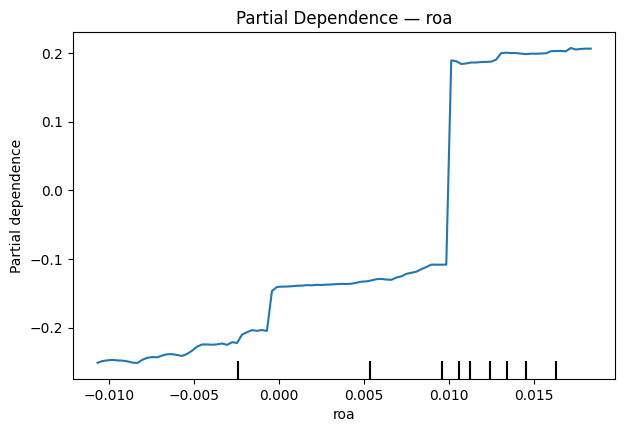

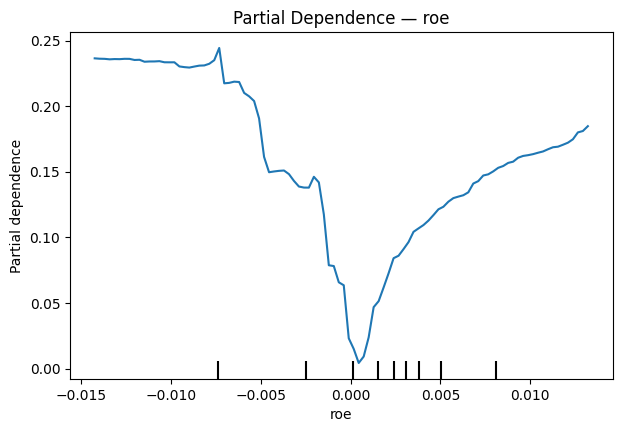

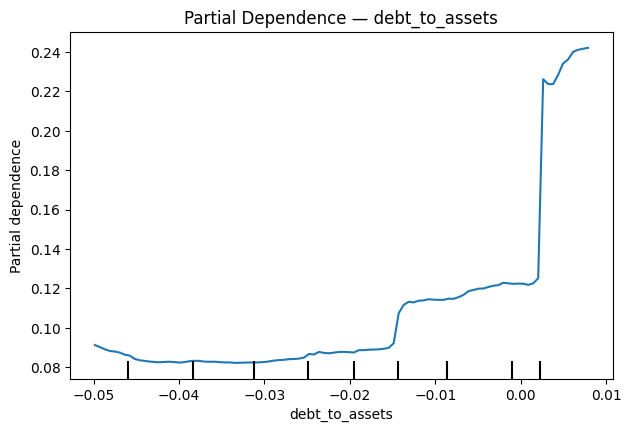

In [ ]:
# Try new-style PDP API; fall back gracefully if unavailable
try:
    from sklearn.inspection import PartialDependenceDisplay as PDPDisp
    _HAS_PDP = True
except Exception:
    _HAS_PDP = False

if _HAS_PDP:
    import matplotlib.pyplot as plt
    for feat in top_feats:
        fig, ax = plt.subplots(figsize=(7,4.5))
        PDPDisp.from_estimator(rf, X_test, [feat], ax=ax, kind="average")
        ax.set_title(f"Partial Dependence — {feat}")
        plt.show()
else:
    # Fallback to old API if needed
    from sklearn.inspection import partial_dependence
    import numpy as np
    import matplotlib.pyplot as plt

    for feat in top_feats:
        j = FEATURE_COLS.index(feat)
        pd_result = partial_dependence(rf, X_test, [j])
        xs = pd_result["values"][0]
        avg = pd_result["average"][0]
        fig, ax = plt.subplots(figsize=(7,4.5))
        ax.plot(xs, avg)
        ax.set_xlabel(feat)
        ax.set_ylabel("Average predicted E/P")
        ax.set_title(f"Partial Dependence — {feat}")
        ax.grid(True, alpha=0.3)
        plt.show()


### Partial Dependence — ROA

**Observations:**
- Clear **S-shaped (sigmoid) relationship** between ROA and predicted E/P.
- Three distinct regions:
  - Below ROA = 0: Relatively flat and negative (around -0.25), representing unprofitable firms.
  - ROA = 0 to 0.010: Sharp upward transition, with predicted E/P jumping from -0.1 to +0.2.
  - Above ROA = 0.010: Levels off around +0.2, representing highly profitable firms.
- The steepest slope occurs right around the profitability threshold (ROA ≈ 0 to 0.005).

**Interpretation:**
The S-curve makes strong financial sense. Firms with negative or zero ROA are fundamentally unprofitable—they destroy value rather than create it, leading to low or negative E/P predictions. As ROA crosses into positive territory, the model rapidly increases E/P predictions, recognizing that profitable operations signal potential undervaluation. Beyond a certain point (ROA > 0.01), returns diminish—additional profitability improvements matter less, possibly because the market already prices in high-quality firms.

The critical transition zone around ROA = 0 reflects a fundamental regime change: the difference between a loss-making and profit-making business is more important than incremental profit improvements among already-profitable firms.

**Implications:**
- Companies near the breakeven point (ROA ≈ 0) are in the highest-leverage zone—small improvements in operational efficiency could dramatically shift their predicted valuation.
- For portfolio screening, filtering out firms with ROA < 0 would eliminate the consistently low-prediction zone, focusing on profitable opportunities.
- The flattening at high ROA suggests diminishing marginal returns to profitability in E/P prediction, consistent with efficient markets pricing in quality.

### Partial Dependence — ROE

**Observations:**
- **V-shaped relationship** with a sharp minimum at ROE ≈ 0.
- High predicted E/P (~0.23) for very negative ROE (< -0.005).
- Steep drop as ROE approaches zero, bottoming out at around +0.01 predicted E/P.
- Gradual recovery as ROE increases beyond zero, reaching about +0.18 for high positive ROE (> 0.010).
- Asymmetric pattern: negative ROE region is higher than the positive ROE recovery.

**Interpretation:**
This V-shape is counterintuitive at first but reveals important dynamics. Firms with very negative ROE (destroying shareholder equity) actually get higher E/P predictions—this likely reflects distressed value situations where earnings are temporarily depressed but the firm has substantial assets. The market may overprice these companies relative to their current earnings, creating high E/P ratios.

The minimum at ROE ≈ 0 represents the worst zone: companies barely breaking even that lack both the stability of profitability and the potential turnaround value of deeply distressed firms. These are "zombie" companies stuck in no-man's-land.

As ROE rises into positive territory, E/P predictions increase, reflecting healthy, equity-generating businesses that may be undervalued—classic value opportunities.

**Implications:**
- Be cautious with companies near zero ROE—the model sees them as the least attractive from an E/P perspective.
- Very negative ROE isn't necessarily a disqualifier; these might be distressed value plays, though they require additional due diligence.
- The model has learned a nonlinear, context-dependent relationship that goes beyond simple "higher profitability = better."

### Partial Dependence — Debt to Assets

**Observations:**
- Nearly flat relationship from debt-to-assets = -0.05 to -0.01, hovering around 0.08-0.09 predicted E/P.
- Moderate upward slope from -0.01 to 0, reaching about 0.11.
- **Sharp exponential increase** beyond debt-to-assets = 0, jumping from 0.12 to 0.24+ as leverage increases.
- The rug plot (tick marks at bottom) shows most data concentrates in the 0 to 0.01 range.

**Interpretation:**
The dramatic upward curve for highly levered firms (debt-to-assets > 0) seems counterintuitive—conventional wisdom suggests high debt increases risk and should lower valuation. However, this pattern likely reflects a selection effect and financial distress dynamics:

1. **Distressed firms with high debt** often have severely depressed stock prices (denominator of E/P), inflating the E/P ratio even if earnings are modest.
2. **Survivorship in the dataset:** Companies with extremely high leverage that are still reporting earnings may represent special situations—restructurings, turnarounds, or industries where high leverage is sustainable.
3. **Value trap signal:** The model may have learned that high debt-to-assets associates with cheap valuations (high E/P), but this doesn't necessarily mean these are good investments—they could be value traps.

The relatively flat region for negative to low positive debt suggests the model doesn't strongly differentiate between underleveraged and moderately leveraged firms.

**Implications:**
- High debt-to-assets firms may trigger high E/P predictions, but users should interpret these cautiously—they likely represent higher-risk, distressed situations rather than genuine value opportunities.
- The model's treatment of leverage is less intuitive than its handling of profitability metrics, suggesting this feature may be capturing complex, nonlinear effects or data artifacts.
- For practical screening, consider imposing maximum leverage thresholds to avoid these potentially misleading high-E/P predictions driven primarily by financial distress rather than fundamental value.

**Overall PDP Takeaway:**
The partial dependence plots confirm the model has learned economically sensible relationships for profitability metrics (ROA, ROE), though with interesting nonlinearities that reflect real-world complexity. The leverage relationship is less straightforward and warrants caution. These plots build confidence that the model isn't just a black box—it's capturing fundamental financial dynamics, even if some patterns require careful interpretation in practical application.

## Stability Over Time: MAE by Year (TEST only)
This plot tracks the model's Mean Absolute Error separately for each year in the test set (2020 and 2021). It reveals whether prediction accuracy degrades over time as the model moves further from its training period (which ended in 2019). Temporal stability is critical in finance because models trained on historical data must generalize to future periods with potentially different economic conditions, market regimes, and company behaviors.
Financial models often suffer from "model drift"—their performance deteriorates as the world changes. Interest rate shifts, regulatory changes, technological disruption, and macro shocks (like COVID-19, which overlaps with our test period) can break previously stable relationships. A model that works well in-sample but degrades rapidly out-of-sample is unreliable for real-world deployment. This analysis tests whether our Random Forest maintains consistent accuracy or if its predictions become less trustworthy over time.

/var/folders/y4/fl18l7792g337_8l96tj5x_w0000gn/T/ipykernel_78877/612327290.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_by_year = test_with_preds.groupby("fyear").apply(


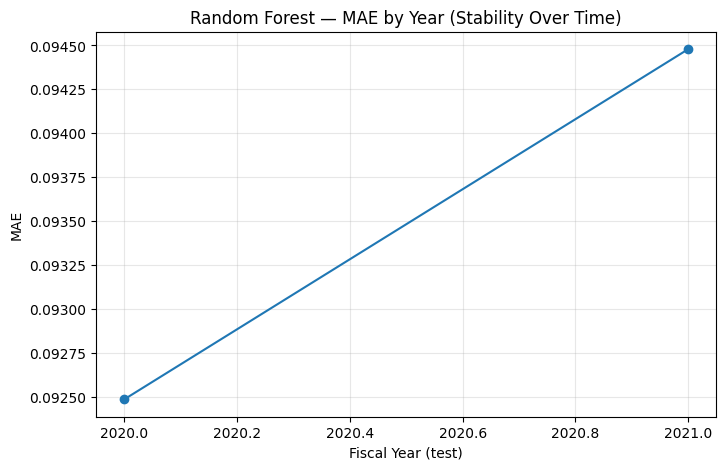

fyear
2020    0.092486
2021    0.094478
dtype: float64

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

test_with_preds = X_test.copy()
# attach IDs and ground truth/preds
test_with_preds[ID_COLS] = test[ID_COLS].reset_index(drop=True)
test_with_preds["y"]     = y_test.values
test_with_preds["yhat"]  = rf.predict(X_test)

mae_by_year = test_with_preds.groupby("fyear").apply(
    lambda d: mean_absolute_error(d["y"], d["yhat"])
)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(mae_by_year.index.astype(int), mae_by_year.values, marker='o')
ax.set_xlabel("Fiscal Year (test)")
ax.set_ylabel("MAE")
ax.set_title("Random Forest — MAE by Year (Stability Over Time)")
ax.grid(True, alpha=0.3)
plt.show()

mae_by_year  # also display the table


**Observations:**
- MAE increases steadily from 2020 to 2021, rising from approximately 0.0925 to 0.0945.
- The degradation is modest—roughly a 2% relative increase over the two-year test window.
- The trend is linear and smooth, with no sudden jumps or erratic behavior.
- Both years remain within a fairly tight error band (0.092-0.095), suggesting the model hasn't completely broken down.

**Interpretation:**
The gradual upward trend indicates mild model drift, which is expected and relatively benign. Several factors could explain this pattern:

1. **Temporal distance from training data:** As we move from 2020 to 2021, the gap between training (pre-2020) and testing widens. Companies evolve, and the model's learned patterns may become slightly less applicable.

2. **COVID-19 impact:** The test period (2020-2021) captures the pandemic and recovery period, introducing unusual volatility and non-stationary dynamics. Traditional financial relationships may have temporarily shifted, making predictions harder.

3. **Changing economic regime:** Interest rates, fiscal policy, and market sentiment all shifted dramatically during this period, potentially altering how features like ROA and debt relate to E/P.

4. **Limited test window:** With only two years, we can't definitively conclude whether this is a persistent trend or just short-term noise.

The model appears reasonably robust to the test period's challenges.

**Implications:**
- **Deployment window:** The model should be reliable for 1-2 years after training before requiring retraining. The modest drift suggests it won't become obsolete immediately.
- **Monitoring protocol:** In production, track MAE monthly or quarterly. If degradation accelerates beyond this baseline trend, trigger model retraining with updated data.
- **Retraining schedule:** Plan to retrain annually or semi-annually to prevent accumulated drift from eroding performance. Incorporate new data to capture evolving market dynamics.
- **Contextual awareness:** The 2020-2021 period was unusually volatile. Future stability may differ depending on macro conditions—stable periods might show less drift, while crisis periods could show more.
- **Relative performance:** Even with drift, the MAE remains low in absolute terms (<0.10), suggesting the model is still useful despite modest degradation.

**Overall takeaway:** The Random Forest demonstrates acceptable temporal stability with only minor performance erosion over the test window. This is reassuring for practical deployment, though regular monitoring and periodic retraining will be essential to maintain accuracy as market conditions continue evolving.

## Correlation Heatmap (Full Feature Set for RF)
A correlation matrix displays the pairwise linear relationships between all features in the model, including financial metrics, corporate culture scores, analyst consensus, and the target variable (E/P). Each cell shows the correlation coefficient between two variables, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation). Red indicates positive correlation, blue indicates negative correlation, and white represents no linear relationship.


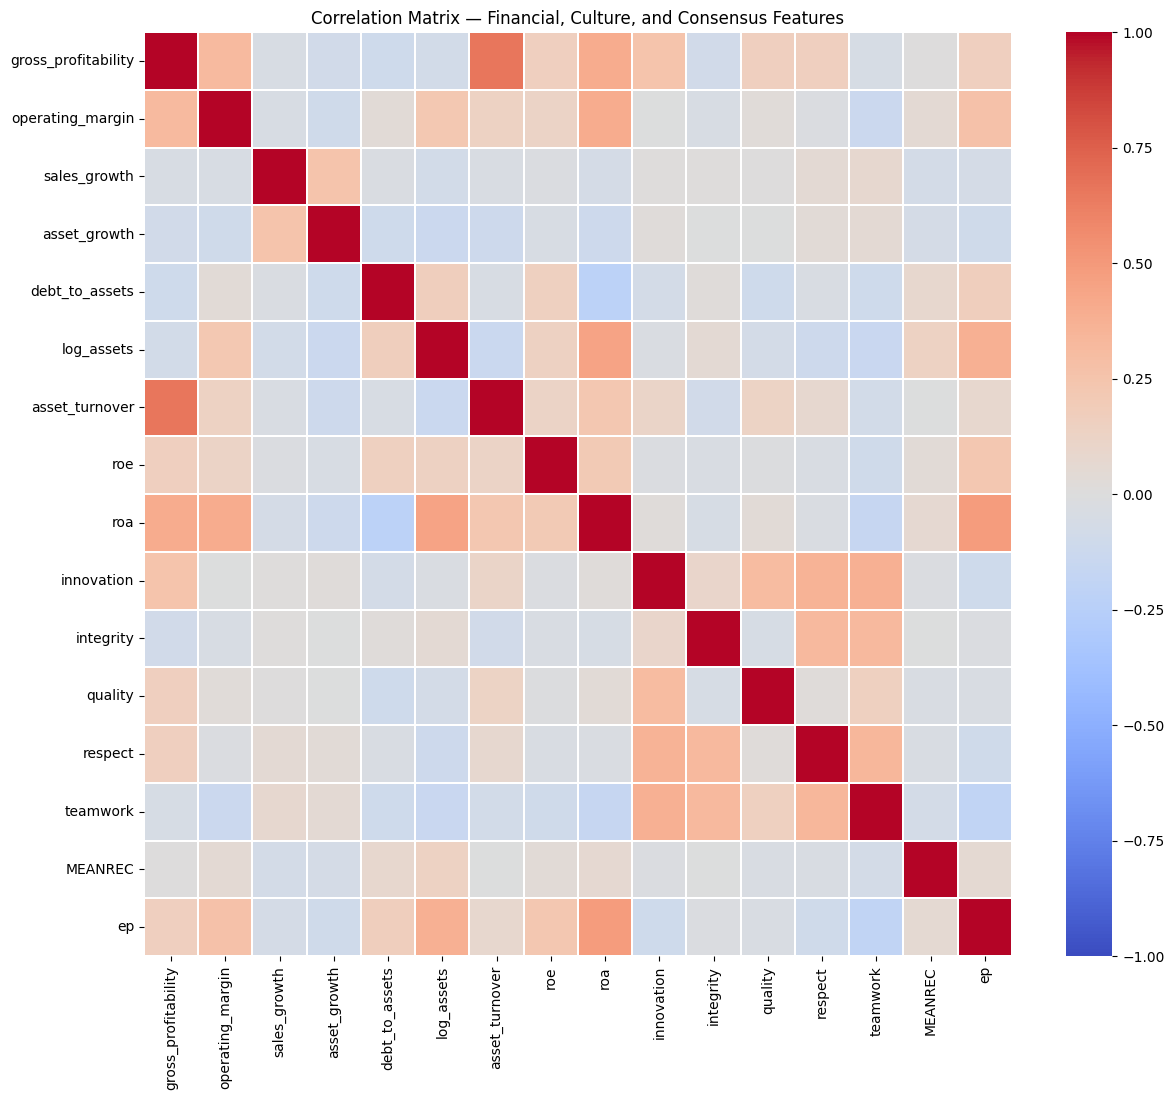

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_features = [
    "gross_profitability","operating_margin","sales_growth","asset_growth",
    "debt_to_assets","log_assets","asset_turnover","roe","roa",
    "innovation","integrity","quality","respect","teamwork",
    "MEANREC","ep"
]

corr_full = train[corr_features].corr()

plt.figure(figsize=(14,12))
sns.heatmap(
    corr_full,
    annot=False,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    linewidths=0.3
)
plt.title("Correlation Matrix — Financial, Culture, and Consensus Features")
plt.show()


**Key Observations:**

**Strong positive correlations (dark red):**
- **ROE and ROA** show moderate positive correlation (~0.5-0.6 range based on color intensity), which makes sense—both measure profitability, though ROE emphasizes equity efficiency while ROA focuses on total assets.
- **Culture dimensions cluster together:** Innovation, integrity, quality, respect, and teamwork all show moderate positive correlations with each other (~0.3-0.5), suggesting they tend to move together. Companies with strong culture in one dimension often score well in others.
- **Profitability metrics:** Gross profitability and operating margin show positive correlation, as expected—companies with high margins tend to be profitable across multiple measures.

**Notable negative correlations (blue):**
- **Debt-to-assets and ROA** show slight negative correlation (light blue), suggesting highly leveraged firms tend to have lower asset profitability—consistent with financial distress dynamics.
- **No strong negative correlations** are visible (no dark blue cells), indicating the absence of obvious inverse relationships in the data.

**Weak or near-zero correlations (white/light colors):**
- **Culture features and financial metrics** show mostly weak correlations. For example, innovation, integrity, quality, respect, and teamwork have minimal correlation with ROA, ROE, or debt ratios. This suggests culture scores add independent information beyond what's captured by traditional financials.
- **MEANREC (analyst consensus)** shows weak correlation with most features, including the target E/P. This is somewhat surprising—analyst recommendations appear to be only loosely connected to fundamental financial metrics in this dataset.
- **Sales and asset growth** show weak correlations with most other features, indicating growth dynamics are relatively independent of profitability and leverage levels.

**Correlations with the target (E/P - bottom row/right column):**
- **ROA and ROE** show the strongest positive correlations with E/P (moderate red), validating the feature importance findings. High profitability associates with higher earnings-to-price ratios.
- **Gross profitability** and **asset turnover** show positive correlations with E/P, though weaker than ROA/ROE.
- **Culture features** show very weak correlations with E/P (nearly white), explaining their minimal predictive power in the Random Forest.
- **Debt-to-assets** shows a positive correlation with E/P (light red), which seems counterintuitive but aligns with the partial dependence plot—highly leveraged firms often have depressed prices, inflating E/P ratios.

**Multicollinearity assessment:**
- No severe multicollinearity is evident—no cells show dark red (r > 0.8) except the diagonal (variables with themselves).
- The moderate correlation between ROA and ROE (~0.5-0.6) is acceptable and expected, as they measure related but distinct concepts.
- Culture dimensions' intercorrelation (~0.3-0.5) suggests some redundancy but not enough to cause major problems.

**Interpretation:**

**Why culture features don't predict well:**
The weak correlations between culture scores and E/P help explain their poor performance in the model. Culture's impact on firm value may be:
1. **Indirect and lagged:** Culture affects long-term outcomes through employee retention, innovation, and reputation, which may not manifest in short-term E/P ratios.
2. **Already captured:** Culture's effects might already be reflected in profitability metrics like ROA—good culture improves operations, which shows up in financial performance.
3. **Measurement issues:** The culture scores themselves may be noisy or not accurately capture the underlying construct.

**Financial intuition holds:**
The correlation patterns validate standard financial relationships:
- Profitability metrics (ROA, ROE, margins) positively correlate with value (E/P).
- Leverage shows complex, context-dependent relationships.
- Growth metrics operate relatively independently of current profitability.

**Model implications:**
- The lack of severe multicollinearity means the Random Forest can effectively use all features without numerical instability.
- The weak culture-financial correlations suggest culture adds independent (though not predictive) information—removing these features likely wouldn't hurt performance.
- The relatively low correlations between most features and E/P (no dark red except ROA/ROE) explain why even the best model struggles with R² in the 0.3-0.4 range—E/P is influenced by many factors beyond what's captured here.

**Implications:**
- **Feature engineering opportunity:** The weak culture correlations suggest these variables need transformation or interaction terms to unlock predictive value, or they should be dropped to simplify the model.
- **Diversification benefit:** Low correlations between feature groups (financial vs. culture vs. consensus) mean they theoretically offer complementary information, though in practice, only financial metrics demonstrate clear predictive power.
- **Model confidence:** The moderate correlations overall (mostly in the 0.2-0.6 range) confirm that E/P is a complex target influenced by multiple factors, justifying the ensemble approach of Random Forests that can capture nonlinear interactions.

**Overall takeaway:** The correlation matrix validates the model's feature importance rankings—profitability metrics with the strongest correlations to E/P also dominate the Random Forest's predictions. The weak performance of culture features is explained by their minimal correlation with the target. No severe multicollinearity issues exist, so all features can coexist in the model without causing instability.